In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from qat.qpus import get_default_qpu
from qat.core import Batch, Job

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.fermion.chemistry.ucc import construct_ucc_ansatz, guess_init_params, get_hf_ket, get_cluster_ops
from qat.qpus import get_default_qpu

from qat.plugins import ScipyMinimizePlugin, MultipleLaunchesAnalyzer

In [2]:
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"


In [3]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.99))]
basis = "sto-3g"
spin = 0
charge = 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)
print(f"Number of qubits before active space selection = {rdm1.shape[0] * 2}")

nqbits = rdm1.shape[0] * 2
print("Number of qubits = ", nqbits)

 HF energy :  -1.0688975010368336
 MP2 energy : -1.0891124176527813
 FCI energy : -1.103247661224499

Number of qubits before active space selection = 4
Number of qubits =  4


/home/huybinh/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.chemistry.ucc import (
    guess_init_params,
    get_hf_ket,
    get_cluster_ops,
)

# Wrap the hamiltonian data into the `MolecularHamiltonian` class.
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)


molecule = MoleculeInfo(hamiltonian=mol_h, n_electrons=n_electrons, noons = False,  orbital_energies=orbital_energies)
print(molecule.nqbits)


4


In [5]:
# Computation of the initial parameters
theta_init = guess_init_params(
    molecule.two_body_integrals,
    molecule.n_electrons,
    molecule.orbital_energies,
)

# Define the initial Hartree-Fock state
ket_hf_init = get_hf_ket(molecule.n_electrons, nqbits=molecule.nqbits)

# Compute the cluster operators
cluster_ops = get_cluster_ops(molecule.n_electrons, nqbits=molecule.nqbits)


# Get the ElectronicStructureHamiltonian
H = molecule.hamiltonian.get_electronic_hamiltonian()


In [6]:
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code, recode_integer

transformation, code = transform_to_jw_basis, get_jw_code

H_sp = transformation(H)
model = H_sp
nqbits = model.nbqbits

# Express the cluster operator in spin terms
cluster_ops_sp = [transformation(t_o) for t_o in cluster_ops]

# Encoding the initial state to new encoding
hf_init_sp = recode_integer(ket_hf_init, code(nqbits))


print("This model has the number of qubit:", model.nbqbits)
print("The number of excitation for this model", len(cluster_ops_sp))
print(model)

This model has the number of qubit: 4
The number of excitation for this model 3
(-0.3215821345068788+0j) * I^4 +
(0.15704511695409992+0j) * (ZZ|[0, 1]) +
(0.1067602885375726+0j) * (ZZ|[0, 2]) +
(0.1557997832872776+0j) * (ZZ|[1, 2]) +
(0.1557997832872776+0j) * (ZZ|[0, 3]) +
(0.1382949122525399+0j) * (Z|[0]) +
(0.1067602885375726+0j) * (ZZ|[1, 3]) +
(0.13829491225253987+0j) * (Z|[1]) +
(0.049039494749704995+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.049039494749704995+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.049039494749704995+0j) * (YYXX|[0, 1, 2, 3]) +
(0.049039494749704995+0j) * (YXXY|[0, 1, 2, 3]) +
(0.16366861628421733+0j) * (ZZ|[2, 3]) +
(-0.13315956580674568+0j) * (Z|[2]) +
(-0.13315956580674568+0j) * (Z|[3])


In [7]:

import itertools
from typing import Any, List, Tuple, Optional, Dict
from bitstring import BitArray
import numpy as np

from qat.core import Term
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X

from qat.fermion.trotterisation import make_spin_hamiltonian_trotter_slice
from qat.fermion.hamiltonians import SpinHamiltonian, FermionHamiltonian
from qat.fermion.util import tobin

def two_loc(
    cluster_ops: List[SpinHamiltonian],
    theta: List[float],
    k: int, # number of excitations
    n_cycles: int = 1,
    rotation_gates: List[Gate] = None,
    entangling_gate: Gate = CNOT,
      
) -> Circuit:
    

    nqbits = cluster_ops[0].nbqbits

    prog = Program()
    reg = prog.qalloc(nqbits)

    # Initialize the Hartree-Fock state into the Program
    for j, char in enumerate(tobin(k, nqbits)):
        if char == "1":
            prog.apply(X, reg[j])
        if char == "0":
            prog.apply(I, reg[j])
    

    print("This applied state is ", tobin(k, nqbits))
    # Define the parameters to optimize

    if rotation_gates is None:
        rotation_gates = [RZ]

    n_rotations = len(rotation_gates)


    ind_theta = 0


    for i in range(nqbits):

        for rot in rotation_gates:

            prog.apply(rot(theta[ind_theta]), reg[i])
            ind_theta += 1
    
    for k in range(n_cycles):


        for i in range(nqbits - 1):
            for j in range(i+1, nqbits):
                prog.apply(CNOT, reg[i], reg[j])
            
        for i in range(nqbits):
            for rot in rotation_gates:
                            
                prog.apply(rot(theta[ind_theta]), reg[i])
                ind_theta += 1

    return prog.to_circ()

In [8]:
n_rotations = 2
n_cycles =3
prog = Program()


rotation_gates = [RY,RZ]

entangling_gate = CNOT

k_lst = [0]

theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(len(theta_0))]

def create_circuit(k):
    return two_loc(cluster_ops_sp, theta, k, n_cycles, rotation_gates, entangling_gate)

# Create and store circuits in a list
circuits_store = [create_circuit(k) for k in k_lst]

# Display the circuits

for circ_dis in circuits_store:
    circ_dis.display()

This applied state is  0000


In [9]:
print(type(circuits_store))

<class 'list'>


#### This is for the ground state 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: -1.103248
         Iterations: 48
         Function evaluations: 2295
         Gradient evaluations: 51
The value of the ground state -1.1032476612244673


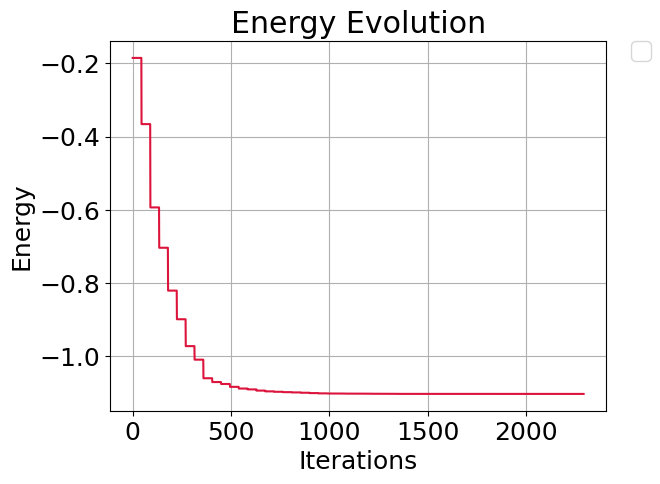

In [10]:
qpu = get_default_qpu()
method = "BFGS"

model = H_sp
nqbits = model.nbqbits

energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
           
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

        return energy
    
    return input_funct

circuits = circuits_store


input_funct = opt_funct(circuits, model, qpu, nqbits, energy_lists)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, options=options)

print("The value of the ground state", Optimizer.fun)

import matplotlib.pyplot as plt
# Plot energy
plt.rcParams["font.size"] = 18
all_energy_lists = []

for i in range(len(circuits_store)):
    energy_ground = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_ground)
    plt.plot(range(len(energy_ground)), energy_ground, color='crimson')


plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.grid(True)
plt.show()


#### This is for the first excited state

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: -0.740375
         Iterations: 92
         Function evaluations: 4365
         Gradient evaluations: 97
The first excited energy state -0.7403748572444759


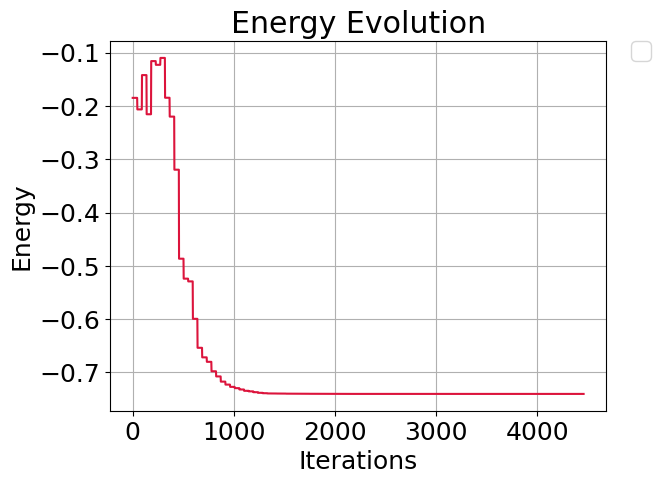

In [11]:
opt_circ = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})
result = qpu.submit(opt_circ.to_job())

beta_1 = 33

def get_statevector_matrix(result, nqbits):

    statevector_mat = np.zeros((2**nqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None

stv_ground_mat= get_statevector_matrix(result, nqbits)


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            

            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)
                


            total_energy = energy + beta_1 * overlap_inp 

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            

            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)


    return input_funct, callback
    

    

circuits = circuits_store

input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print("The first excited energy state", Optimizer.fun)

for i in range(len(circuits_store)):
    energy_ground = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_ground)
    plt.plot(range(len(energy_ground)), energy_ground, color='crimson')


plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.grid(True)
plt.show()

#### This one is for the second exicited state

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: -0.740375
         Iterations: 266
         Function evaluations: 14715
         Gradient evaluations: 327
The second excited state energy is  -0.7403748570967728


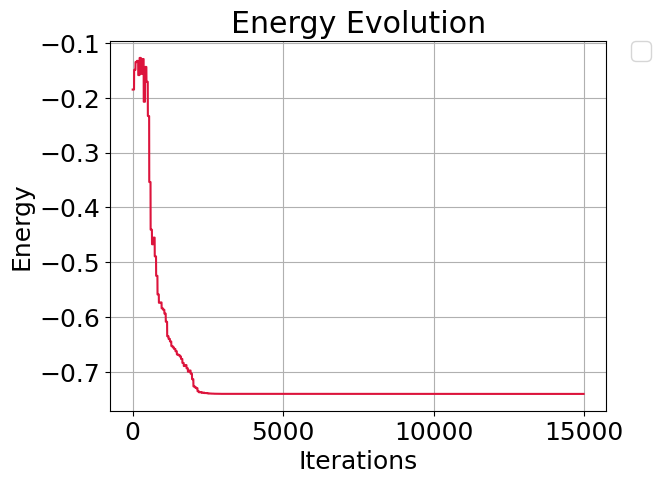

In [12]:
opt_circ = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})
result = qpu.submit(opt_circ.to_job())

beta_2 = 44

def get_statevector_matrix(result, nqbits):

    statevector_mat = np.zeros((2**nqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None

stv_exci_mat= get_statevector_matrix(result, nqbits)


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1, beta_2):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)


            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)
            overlap_inp_exci = overlap(bound_circ, stv_exci_mat)
                


            total_energy = energy + beta_1 * overlap_inp + beta_2 * overlap_inp_exci

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            

            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)
            overlap_inp_exci = overlap(bound_circ, stv_exci_mat)


    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1, beta_2)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print("The second excited state energy is ", Optimizer.fun)



for i in range(len(circuits_store)):
    energy_ground = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_ground)
    plt.plot(range(len(energy_ground)), energy_ground, color='crimson')


plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.grid(True)
plt.show()

#### : This is the third excited state 

/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


         Current function value: -0.740375
         Iterations: 309
         Function evaluations: 16257
         Gradient evaluations: 361
The third excited state energy is  -0.7403748520951187


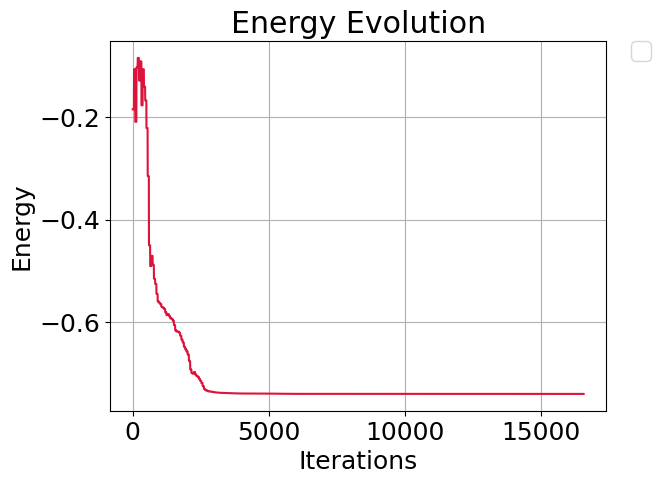

In [13]:
opt_circ = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})

result = qpu.submit(opt_circ.to_job())

beta_3 = 55

def get_statevector_matrix(result, nqbits):

    statevector_mat = np.zeros((2**nqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None

stv_exci_mat_t = get_statevector_matrix(result, nqbits)


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1, beta_2, beta_3):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            

            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)
            overlap_inp_exci = overlap(bound_circ, stv_exci_mat)
            overlap_inp_exci_t = overlap(bound_circ, stv_exci_mat_t)
                

            total_energy = energy + beta_1 * overlap_inp + beta_2 * overlap_inp_exci + beta_3 * overlap_inp_exci_t

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            

            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)
            overlap_inp_exci = overlap(bound_circ, stv_exci_mat)
            overlap_inp_exci_t = overlap(bound_circ, stv_exci_mat_t)

    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1, beta_2, beta_3)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print("The third excited state energy is ", Optimizer.fun)



for i in range(len(circuits_store)):
    energy_ground = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_ground)
    plt.plot(range(len(energy_ground)), energy_ground, color='crimson')

    # Print the final energy for each k
    final_energy = energy_ground

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.grid(True)
plt.show()

#### The forth excited state

/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


         Current function value: -0.604795
         Iterations: 77
         Function evaluations: 4825
         Gradient evaluations: 107
The forth excited state energy is  -0.6047954110227982


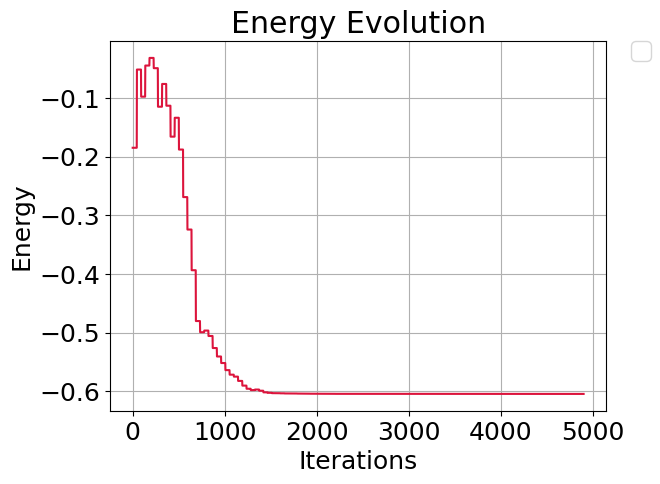

In [15]:
opt_circ = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})


result = qpu.submit(opt_circ.to_job())

beta_4 =66

def get_statevector_matrix(result, nqbits):

    statevector_mat = np.zeros((2**nqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None

stv_exci_mat_q = get_statevector_matrix(result, nqbits)


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1, beta_2, beta_3, beta_4):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            

            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)
            overlap_inp_exci = overlap(bound_circ, stv_exci_mat)
            overlap_inp_exci_t = overlap(bound_circ, stv_exci_mat_t)
            overlap_inp_exci_q = overlap(bound_circ, stv_exci_mat_q)
                


            total_energy = energy + beta_1 * overlap_inp + beta_2 * overlap_inp_exci + beta_3 * overlap_inp_exci_t + beta_4 * overlap_inp_exci_q

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            

            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)
            overlap_inp_exci = overlap(bound_circ, stv_exci_mat)
            overlap_inp_exci_t = overlap(bound_circ, stv_exci_mat_t)
            overlap_inp_exci_q = overlap(bound_circ, stv_exci_mat_q)

    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1, beta_2, beta_3 , beta_4)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print("The forth excited state energy is ", Optimizer.fun)



for i in range(len(circuits_store)):
    energy_ground = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_ground)
    plt.plot(range(len(energy_ground)), energy_ground, color='crimson')

    # Print the final energy for each k
    final_energy = energy_ground

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.grid(True)
plt.show()

/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


         Current function value: -0.581278
         Iterations: 99
         Function evaluations: 5772
         Gradient evaluations: 128
The fifth excited state energy is  -0.5812777667574117


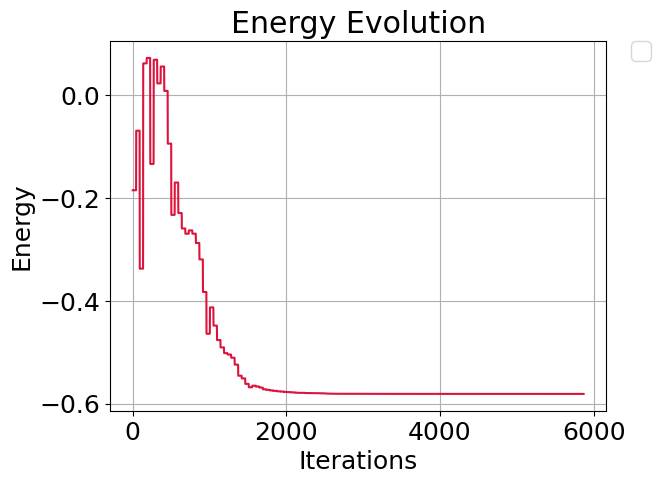

In [16]:
opt_circ = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})

result = qpu.submit(opt_circ.to_job())

beta_5 =88

def get_statevector_matrix(result, nqbits):

    statevector_mat = np.zeros((2**nqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None

stv_exci_mat_k = get_statevector_matrix(result, nqbits)


energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1, beta_2, beta_3, beta_4, beta_5):
    
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            

            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)
            overlap_inp_exci = overlap(bound_circ, stv_exci_mat)
            overlap_inp_exci_t = overlap(bound_circ, stv_exci_mat_t)
            overlap_inp_exci_q = overlap(bound_circ, stv_exci_mat_q)
            overlap_inp_exci_k = overlap(bound_circ, stv_exci_mat_k)
                
                

            total_energy = energy + beta_1 * overlap_inp + beta_2 * overlap_inp_exci + beta_3 * overlap_inp_exci_t + beta_4 * overlap_inp_exci_q + beta_5 * overlap_inp_exci_k

        return total_energy
    

    def callback(x):
        
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
            result = qpu.submit(job_exci_inp)

            

            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            overlap_inp = overlap(bound_circ, stv_ground_mat)
            overlap_inp_exci = overlap(bound_circ, stv_exci_mat)
            overlap_inp_exci_t = overlap(bound_circ, stv_exci_mat_t)
            overlap_inp_exci_q = overlap(bound_circ, stv_exci_mat_q)
            overlap_inp_exci_k = overlap(bound_circ, stv_exci_mat_k)

    return input_funct, callback
    


circuits = circuits_store



input_funct, callback = opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_1, beta_2, beta_3 , beta_4, beta_5)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

print("The fifth excited state energy is ", Optimizer.fun)



for i in range(len(circuits_store)):
    energy_ground = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_ground)
    plt.plot(range(len(energy_ground)), energy_ground, color='crimson')


plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.grid(True)
plt.show()

## I need to debug this one 
 

This applied state is  0000
This applied state is  0001
This applied state is  0010


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: -2.196209
         Iterations: 233
         Function evaluations: 11430
         Gradient evaluations: 254
The 3-th excited state energy is -2.19620863233408


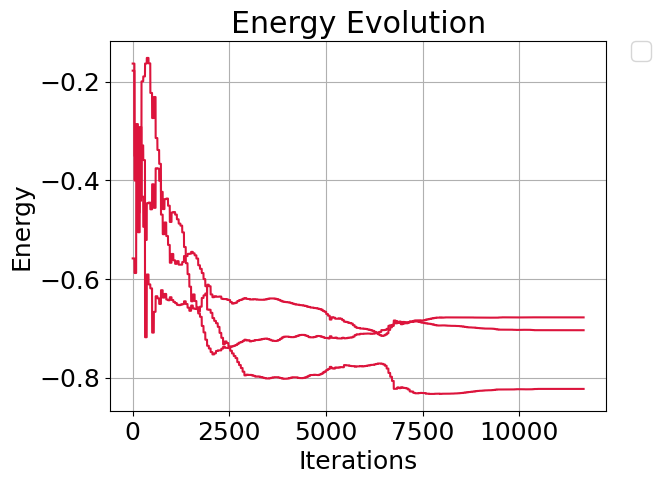

In [22]:
def optimize_excited_state(k, beta_values):
    qpu = get_default_qpu()
    method = "BFGS"
    model = H_sp
    nqbits = model.nbqbits

    energy_lists = {f"energy_circ_{i}": {method: []} for i in range(k)}

    stv_exci_mats = []

    def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_values):
        def input_funct(x):
            total_energy = 0
            for i, circ in enumerate(circuits):
                bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
                job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
                result = qpu.submit(job_exci_inp)

                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                total_energy += energy
                for j in range(i + 1):  # Loop through the already computed overlap terms
                    overlap_inp = overlap(bound_circ, stv_exci_mats[j])
                    total_energy += beta_values[j] * overlap_inp

            return total_energy

        def callback(x):
            for i, circ in enumerate(circuits):
                bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
                job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
                result = qpu.submit(job_exci_inp)

                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                for j in range(i + 1):
                    overlap_inp = overlap(bound_circ, stv_exci_mats[j])

        return input_funct, callback

    circuits_store = [create_circuit(k) for k in range(k)]
    theta_0 = [np.random.uniform(0, 2 * np.pi) for _ in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]

    for i in range(k):
        opt_circ = circuits_store[i].bind_variables({k: v for k, v in zip(sorted(circuits_store[i].get_variables()), theta_0)})
        result = qpu.submit(opt_circ.to_job())
        stv_exci_mats.append(get_statevector_matrix(result, nqbits))

    input_funct, callback = opt_funct(circuits_store, model, qpu, nqbits, energy_lists, beta_values)
    options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
    Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)


    for i in range(k):
        energy_ground = energy_lists[f"energy_circ_{i}"][method]
        plt.plot(range(len(energy_ground)), energy_ground, color='crimson')

    plt.xlabel("Iterations")
    plt.ylabel("Energy")
    plt.title("Energy Evolution")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    plt.grid(True)
    plt.show()

# Example usage for the 5-th excited state
k_value = 3
beta_values = [11, 22, 33]  # Replace with appropriate beta values
optimize_excited_state(k_value, beta_values)


In [33]:
def get_statevector_matrix(result, nqbits):

    statevector_mat = np.zeros((2**nqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat

def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return None


def optimize_excited_state(k, beta_values):
    qpu = get_default_qpu()
    method = "BFGS"
    model = H_sp
    nqbits = model.nbqbits

    energy_lists = {f"energy_circ_{i}": {method: []} for i in range(k)}

    stv_exci_mats = []

    def opt_funct(circuits, model, qpu, nqbits, energy_lists, beta_values):
        def input_funct(x):
            total_energy = 0
            for i, circ in enumerate(circuits):
                bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
                job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
                result = qpu.submit(job_exci_inp)

                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                total_energy += energy
                for j in range(i + 1):  # Loop through the already computed overlap terms
                    overlap_inp = overlap(bound_circ, stv_exci_mats[j])
                    total_energy += beta_values[j] * overlap_inp

            return total_energy

        def callback(x):
            for i, circ in enumerate(circuits):
                bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
                job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
                result = qpu.submit(job_exci_inp)

                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
                for j in range(i + 1):
                    overlap_inp = overlap(bound_circ, stv_exci_mats[j])

        return input_funct, callback

    circuits_store = [create_circuit(k) for k in range(k)]
    theta_0 = [np.random.uniform(0, 2 * np.pi) for _ in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]

    for i in range(k):
        opt_circ = circuits_store[i].bind_variables({k: v for k, v in zip(sorted(circuits_store[i].get_variables()), theta_0)})
        result = qpu.submit(opt_circ.to_job())
        stv_exci_mats.append(get_statevector_matrix(result, nqbits))

    input_funct, callback = opt_funct(circuits_store, model, qpu, nqbits, energy_lists, beta_values)
    options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
    Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)

    plt.rcParams["font.size"] = 18
    all_energy_lists = []


    for i in range(k):
        energy_list = energy_lists[f"energy_circ_{i}"][method]
        all_energy_lists.append(energy_list)
        plt.plot(range(len(energy_list)), energy_list, label=f"Energy for k={binary_repr(k_lst[i]).zfill(4)}")

        # Print the final energy for each k
        final_energy = energy_list[-1]
        print(f"Final energy for k={binary_repr(k_lst[i]).zfill(4)}: {final_energy}")
        
    plt.xlabel("Iterations")
    plt.ylabel("Energy")
    plt.title("Energy Evolution")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
    plt.grid(True)
    plt.show()

# Example usage for the 5-th excited state
k_value = 3
beta_values = [11, 22, 33]  # Replace with appropriate beta values
optimize_excited_state(k_value, beta_values)


This applied state is  0000
This applied state is  0001
This applied state is  0010
